In [1]:
import math
import statistics
import pandas as pd
import numpy as np
import itertools
import igraph 
import warnings
from notears_custom import linear
from notears_custom import utils
import os
from sklearn.linear_model import Lasso, LinearRegression
import datetime
import matplotlib.pyplot as plt
import rpy2
%matplotlib inline

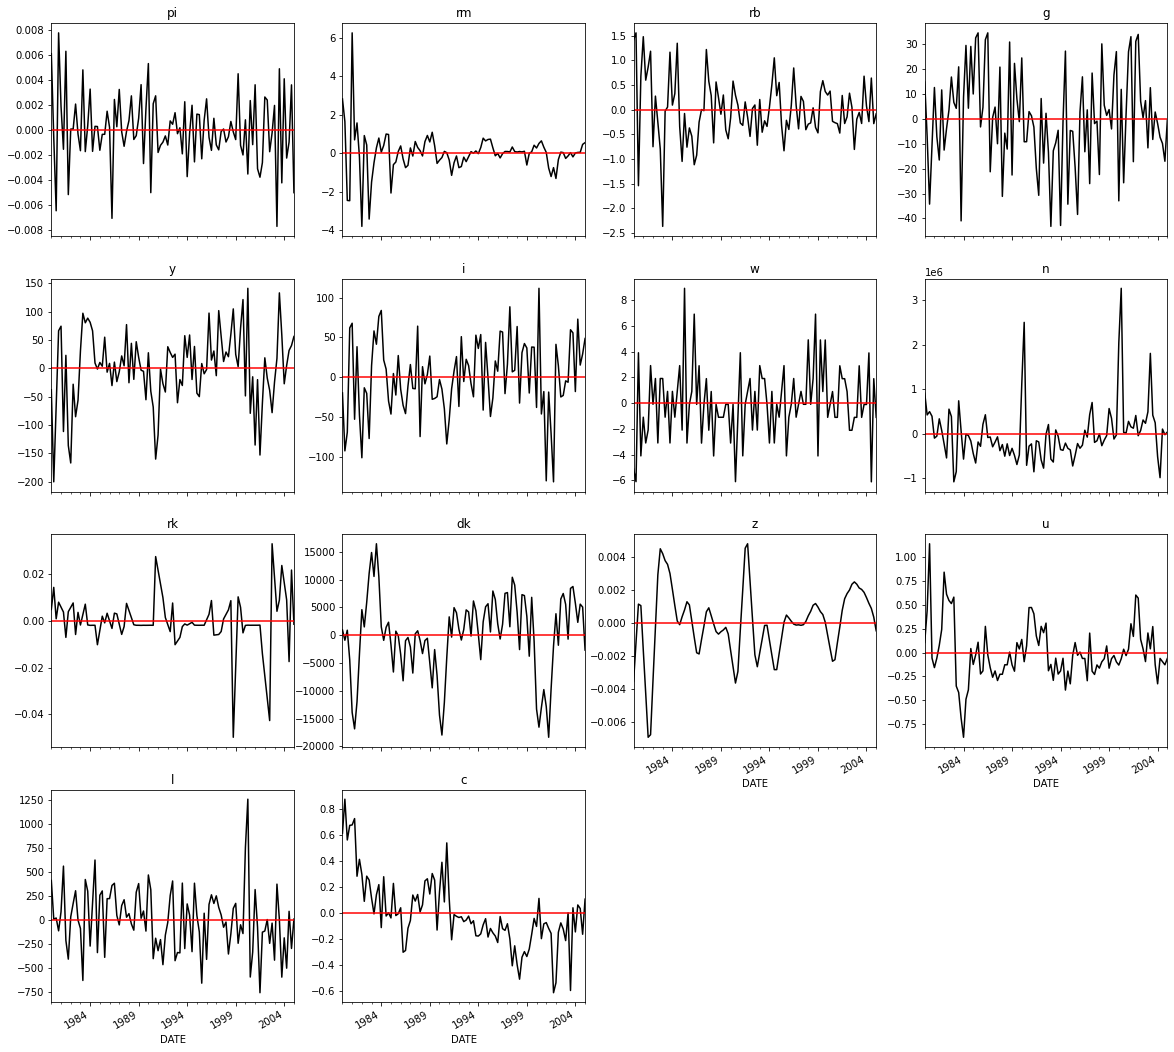

In [99]:
axes = data.plot(subplots=True, layout=(4,4), figsize=(20,20), color="black", legend=False)
for ax, name in zip(axes.flatten(), data.columns.values):
    ax.axhline(y=0, color="red")
    ax.set_title(name)

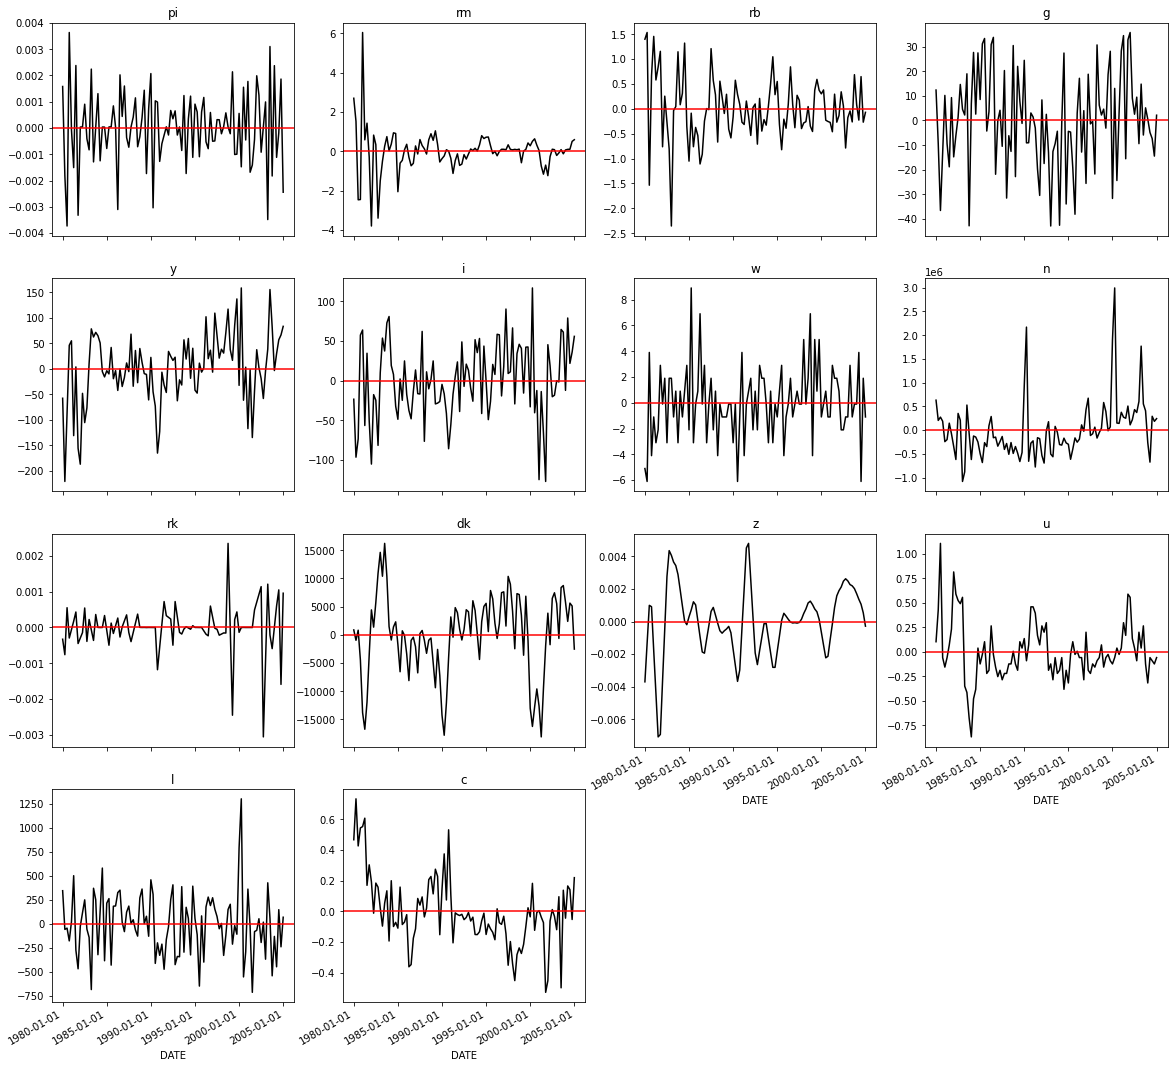

In [69]:
data = pd.read_csv('../data/real_data.csv', index_col='DATE')
axes = data.plot(subplots=True, layout=(4,4), figsize=(20,20), color="black", legend=False)
for ax, name in zip(axes.flatten(), data.columns.values):
    ax.axhline(y=0, color="red")
    ax.set_title(name)

In [139]:
data.to_csv('../data/real_data.csv')

In [7]:
shift_vars = data.columns.values
shift = data.loc[:,shift_vars].shift()
shift.columns = [str(col) + '_1' for col in shift.columns]
data = pd.concat([data, shift], axis=1)
data = data.iloc[1:,:]
Y = data.iloc[:,:14]
X = data.iloc[:,14:]

In [8]:
def lasso_grid_search(X, Y, a_min=-5, a_max=5, T=100, verbose=True, **kwargs):
    results = pd.DataFrame(columns=['alpha', 'states', 'coefs', 'model'])
    i = 1
    for alpha in np.logspace(a_min, a_max, T):
        if verbose:
            print('Beginning iteration {} of {} ({}%) --- alpha = {}'.format(i, T, np.round((i/T)*100, 2), alpha))
        model = Lasso(alpha=alpha, **kwargs)
        model.fit(X, Y)
        coefs = pd.DataFrame(model.coef_, columns=X.columns, index=Y.columns)
        states = coefs.loc[:,(coefs != 0).any()].columns.values
        result = {'alpha': alpha, 'states': states, 'coefs': coefs, 'model': model}
        results = results.append(result, ignore_index=True)
        i += 1
    return results

In [10]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lasso_results = lasso_grid_search(X, Y, T=100, a_min=-1, a_max=10,max_iter=1000000, fit_intercept = False, normalize = True)

Beginning iteration 1 of 100 (1.0%) --- alpha = 0.1
Beginning iteration 2 of 100 (2.0%) --- alpha = 0.1291549665014884
Beginning iteration 3 of 100 (3.0%) --- alpha = 0.16681005372000587
Beginning iteration 4 of 100 (4.0%) --- alpha = 0.21544346900318834
Beginning iteration 5 of 100 (5.0%) --- alpha = 0.2782559402207124
Beginning iteration 6 of 100 (6.0%) --- alpha = 0.35938136638046275
Beginning iteration 7 of 100 (7.0%) --- alpha = 0.46415888336127786
Beginning iteration 8 of 100 (8.0%) --- alpha = 0.5994842503189409
Beginning iteration 9 of 100 (9.0%) --- alpha = 0.774263682681127
Beginning iteration 10 of 100 (10.0%) --- alpha = 1.0
Beginning iteration 11 of 100 (11.0%) --- alpha = 1.291549665014884
Beginning iteration 12 of 100 (12.0%) --- alpha = 1.6681005372000584
Beginning iteration 13 of 100 (13.0%) --- alpha = 2.1544346900318834
Beginning iteration 14 of 100 (14.0%) --- alpha = 2.7825594022071245
Beginning iteration 15 of 100 (15.0%) --- alpha = 3.593813663804626
Beginning it

In [98]:
cpi = pd.read_csv('../data/real_data/CPIAUCSL.csv', index_col='DATE').replace('.', np.nan).astype(np.float64)
i__ = pd.read_csv('../data/real_data/DFF.csv', index_col='DATE').replace('.', np.nan).astype(np.float64)
rb_ = pd.read_csv('../data/real_data/DGS10.csv', index_col='DATE').replace('.', np.nan).astype(np.float64)
gr_ = pd.read_csv('../data/real_data/GCEC1.csv', index_col='DATE').replace('.', np.nan).astype(np.float64)
yr_ = pd.read_csv('../data/real_data/GDPC1.csv', index_col='DATE').replace('.', np.nan).astype(np.float64)
ir_ = pd.read_csv('../data/real_data/GPDIC1.csv', index_col='DATE').replace('.', np.nan).astype(np.float64)
wr_ = pd.read_csv('../data/real_data/LES1252881600Q.csv', index_col='DATE').replace('.', np.nan).astype(np.float64)
n__ = pd.read_csv('../data/real_data/LFWA64TTUSM647S.csv', index_col='DATE').replace('.', np.nan).astype(np.float64)
rk_ = pd.read_csv('../data/real_data/NASDAQCOM.csv', index_col='DATE').replace('.', np.nan).astype(np.float64)
kr_ = pd.read_csv('../data/real_data/RKNANPUSA666NRUG.csv', index_col='DATE').replace('.', np.nan).astype(np.float64)
tfp = pd.read_csv('../data/real_data/RTFPNAUSA632NRUG.csv', index_col='DATE').replace('.', np.nan).astype(np.float64)
une = pd.read_csv('../data/real_data/UNRATE.csv', index_col='DATE').replace('.', np.nan).astype(np.float64)
l__ = pd.read_csv('../data/real_data/CLF16OV.csv', index_col='DATE').replace('.', np.nan).astype(np.float64)
cr_ = pd.read_csv('../data/real_data/PCEPI.csv', index_col='DATE').replace('.', np.nan).astype(np.float64)
ts = [cpi, i__, rb_, gr_, yr_, ir_, wr_, n__, rk_, kr_, tfp, une, l__, cr_]
for t in ts:
    t.index = pd.to_datetime(t.index)
    
# Calculate inflation from CPI
cpi = cpi.join(cpi.shift(), rsuffix='_1')
cpi = pd.DataFrame(cpi.apply(lambda x: (x[0] - x[1])/x[1], axis=1), columns=['pi']).reindex(yr_.index)
# Convert to quarterly inflation
cpi = cpi.rolling('90D').sum().reindex(yr_.index)
# Convert to average quarterly federal funds rate
i__ = i__.rolling('90D').mean().reindex(yr_.index)
i__.columns = ['rm']
# Convert to average quarterly 10y bond rate
rb_ = rb_.resample('D').ffill().rolling('90D').mean().reindex(yr_.index)
rb_.columns = ['rb']
# Real governnment expendiature
gr_ = gr_.reindex(yr_.index)
gr_.columns = ['g']
# Real GDP 
yr_ = yr_
yr_.columns = ['y']
# Real investment
ir_ = ir_.reindex(yr_.index)
ir_.columns = ['i']
# Real (median) Wages
wr_ = wr_.reindex(yr_.index)
wr_.columns = ['w']
# Population
n__ = n__.rolling('90D').sum().reindex(yr_.index)
n__.columns = ['n']
# Real return to capital (estimated via NASDAQ)
rk_ = rk_.resample('D').ffill()
rk_ = rk_.join(rk_.shift(), rsuffix='_1').join(cpi, how='right')
rk_['rk'] = ((rk_['NASDAQCOM'] - rk_['NASDAQCOM_1']) / rk_['NASDAQCOM_1']) - (cpi['pi']/90)
rk_ = pd.DataFrame(rk_['rk'], columns=['rk']).reindex(yr_.index)
# Real capital stock
kr_ = kr_.reindex(yr_.index).interpolate(method='polynomial', order=2)
kr_ = (kr_.iloc[:,0] - kr_.iloc[:,0].shift()).to_frame().dropna()
kr_.columns = ['dk']
# Total factor productivity
tfp = tfp.reindex(yr_.index).interpolate(method='polynomial', order=2)
tfp.columns = ['z']
# Unemployment
une = une.rolling('90D').mean().reindex(yr_.index)
une.columns = ['u']
# Total Labor
l__ = l__.rolling('90D').mean().reindex(yr_.index)
l__.columns = ['l']
# Real Consumption
cr_ = cr_.rolling('90D').mean().reindex(yr_.index)
cr_.columns = ['c']

ts = [cpi, i__, rb_, gr_, yr_, ir_, wr_, n__, rk_, kr_, tfp, une, l__, cr_]

# Transform to deviations from x lag trend
lags = 1
for i in range(len(ts)):
    t = ts[i]
    model = LinearRegression(fit_intercept=False)
    X = np.array([t.dropna().shift(i+1).iloc[lags:,0].values.reshape(-1,1) for i in range(lags)]).reshape(-1, lags)   
    y = t.dropna().iloc[lags:,0].values.reshape(-1,1)
    model.fit(X, y)
    ts[i] = pd.DataFrame(y - model.predict(X),
                         index=t.dropna().iloc[lags:,0].index, 
                         columns=t.columns)
    
data = pd.DataFrame(index=yr_.index)
for t in ts:
    data = data.join(t, how='left')
data = data.interpolate().loc['1980-01-01':'2005-01-01']
data = data.apply(lambda x: x - x.mean())

In [11]:
for states in lasso_results['states']:
    print(states)

['pi_1' 'rm_1' 'rb_1' 'g_1' 'y_1' 'i_1' 'w_1' 'n_1' 'rk_1' 'dk_1' 'z_1'
 'u_1' 'l_1' 'c_1']
['pi_1' 'rm_1' 'rb_1' 'g_1' 'y_1' 'i_1' 'w_1' 'n_1' 'rk_1' 'dk_1' 'z_1'
 'u_1' 'l_1' 'c_1']
['pi_1' 'rm_1' 'rb_1' 'g_1' 'y_1' 'i_1' 'w_1' 'n_1' 'rk_1' 'dk_1' 'z_1'
 'u_1' 'l_1' 'c_1']
['pi_1' 'rm_1' 'rb_1' 'g_1' 'y_1' 'i_1' 'w_1' 'n_1' 'rk_1' 'dk_1' 'z_1'
 'u_1' 'l_1' 'c_1']
['pi_1' 'rm_1' 'rb_1' 'g_1' 'y_1' 'i_1' 'w_1' 'n_1' 'rk_1' 'dk_1' 'z_1'
 'u_1' 'l_1' 'c_1']
['pi_1' 'rm_1' 'rb_1' 'g_1' 'y_1' 'i_1' 'w_1' 'n_1' 'rk_1' 'dk_1' 'z_1'
 'u_1' 'l_1' 'c_1']
['pi_1' 'rm_1' 'rb_1' 'g_1' 'y_1' 'i_1' 'w_1' 'n_1' 'rk_1' 'dk_1' 'z_1'
 'u_1' 'l_1' 'c_1']
['pi_1' 'rm_1' 'rb_1' 'g_1' 'y_1' 'i_1' 'w_1' 'n_1' 'rk_1' 'dk_1' 'z_1'
 'u_1' 'l_1' 'c_1']
['pi_1' 'rm_1' 'rb_1' 'g_1' 'y_1' 'i_1' 'w_1' 'n_1' 'rk_1' 'dk_1' 'z_1'
 'u_1' 'l_1' 'c_1']
['pi_1' 'rm_1' 'rb_1' 'g_1' 'y_1' 'i_1' 'w_1' 'n_1' 'rk_1' 'dk_1' 'z_1'
 'u_1' 'l_1' 'c_1']
['pi_1' 'rm_1' 'rb_1' 'g_1' 'y_1' 'i_1' 'w_1' 'n_1' 'rk_1' 'dk_1' 'z_1'
 'u_1' '

In [12]:
class dag():
    
    def __init__(self, m):
        '''
        m is a pandas DataFrame conaining an adjacency matrix
        '''
        self.m = m
        self.nodes = self.m.columns.values
        self.lags = np.array([n for n in self.nodes if '_1' in n])
        if not all(self.m.columns.values == self.m.index.values):
            raise ValueError('Invalid adjacency matrix (columns and rows are not the same)')
        self.directed = self.directed()

            
    def parents(self, n):
        '''
        n is a node in the graph
        '''
        if n not in self.nodes:
            raise ValueError('n is not in graph')
        return self.m.loc[self.m.loc[:,n] != 0, n].index.values
    
    
    def children(self, n):
        '''
        n is a node in the graph
        '''
        if n not in self.nodes:
            raise ValueError('n is not in graph')
        return self.m.loc[:,self.m.loc[n,:] != 0].columns.values
    
    
    def directed(self):
        return utils.is_dag(self.m.values)
        
    
    def depth(self, n):
        '''
        n is a node in the graph
        return the length of the shortest path to a root node
        '''
        if not self.directed:
            raise ValueError('Cannot compute depth, graph is undirected')
        if len(self.parents(n)) == 0:
            return 0
        else:
            return 1 + max([self.depth(p) for p in self.parents(n)])
    
    
    def root_nodes(self):
        return np.array([n for n in self.nodes if len(self.parents(n)) == 0])
        
        
    def isolated_nodes(self):
        return np.array([n for n in d.nodes if (len(d.parents(n)) == 0) & (len(d.children(n)) == 0)])
    
    
    def connected_roots(self):
        return np.array([n for n in d.nodes if (len(d.parents(n)) == 0) & (len(d.children(n)) > 0)])
    
    
    def structure(self):
        M = self.m.copy()
        M[M != 0] = 1
        return M
    
    
    def shd(self, d):
        try:
            return utils.count_accuracy(d.structure().values, self.structure().values)['shd']
        except ValueError as e:
            # Graph is not directed
            return None
    
    
    def impute(self, values):
        na_nodes = values[values.isna()]
        depth = 0
        try:
            max_depth = max([self.depth(n) for n in self.nodes])
        except ValueError as e:
            print('Cannot impute values as graph is not directed')
            raise e
        while depth <= max_depth:
            for node in na_nodes.index:
                if self.depth(node) == depth:
                    values[node] = np.dot(self.m.loc[:,node], values.fillna(0))
            depth += 1
        return values


    def calculate_irf(self, x_0, T=250, verbose=False):
        if verbose:
            print('Simulating irf...')
        for lag in self.lags:
            x_0[lag] = 0
        irf = pd.DataFrame([self.impute(x_0)], columns=self.nodes)
        for t in range(T-1):
            if verbose:
                print('Simulating t={} of {} ({}%)'.format(t+1, T, np.round(100 * ((t+1)/T), decimals=2)))
            nr = pd.Series(np.full(len(self.nodes), np.nan), index=self.nodes)
            for lag in self.lags:
                nr[lag] = irf.iloc[-1,:][lag.rstrip('_1')]
            nr = self.impute(nr)    
            irf = irf.append(nr, ignore_index=True)
        irf.loc[:,'t'] = range(T)
        irf.set_index('t', inplace=True)
        irf.drop(self.lags, axis=1, inplace=True)
        return irf


    def plot_irf(self, irf, layout=None):
        if layout is None:
            side = math.ceil(math.sqrt(len(irf.columns)))
            layout = (side, side)
        axes = irf.plot(subplots=True, layout=layout, 
                        color="black", legend=False)
        for ax, name in zip(axes.flatten(), irf.columns.values):
            ax.axhline(y=0, color="red")
            ax.set_title(name)
        return plt
    
    
    def plot_structure(self):
        M = self.m.values
        g = igraph.Graph.Adjacency((M != 0.0).tolist())
        g.es['weight'] = M[M.nonzero()]
        g.vs['label'] = self.nodes
        g.vs['color'] = 'white'
        g.vs['size'] = 45
        return g

In [13]:
tol = 0.01
bl_children = np.where(np.isin(data.columns.values, shift.columns.values))[0]
bl_parents  = None 
d = data.shape[1]
bnds = [
        (0, 0)
        if i == j
        else (0 + tol, 1 - tol)
        if j == i - d/2
        else (0, 0) 
        if bl_parents is not None and i in bl_parents
        else (0, 0) 
        if bl_children is not None and j in bl_children
        else (None, None) 
        for i in range(d)
        for j in range(d)
    ] 

In [25]:
W_est = linear.notears_linear(data.values, 
                              max_iter=1000,
                              bnds=bnds,
                              verbose=True,
                              w_threshold=(tol/2),
                              lambda1=1e-4, 
                              h_tol=1e-25, 
                              rho_max=1e+25,
                              loss_type='logistic')
adj_df = pd.DataFrame(W_est, index=data.columns.values, columns=data.columns.values)
dg = dag(adj_df)

Completed iteration 1
h: 2237651.8592323987
rho: 1.0
Completed iteration 2
h: 2800.494392292002
rho: 1.0
Completed iteration 3
h: 689.42097170353
rho: 100000.0
Completed iteration 4
h: 128.07045336249948
rho: 1000000.0
Completed iteration 5
h: 11.688170414401611
rho: 100000000.0
Completed iteration 6
h: 0.4942450726526424
rho: 1000000000000.0
Completed iteration 7
h: 0.10108837631223722
rho: 10000000000000.0
Completed iteration 8
h: 0.02414317869018845
rho: 1e+17
Algorithm reached terminal condition


In [26]:
dg.directed

False

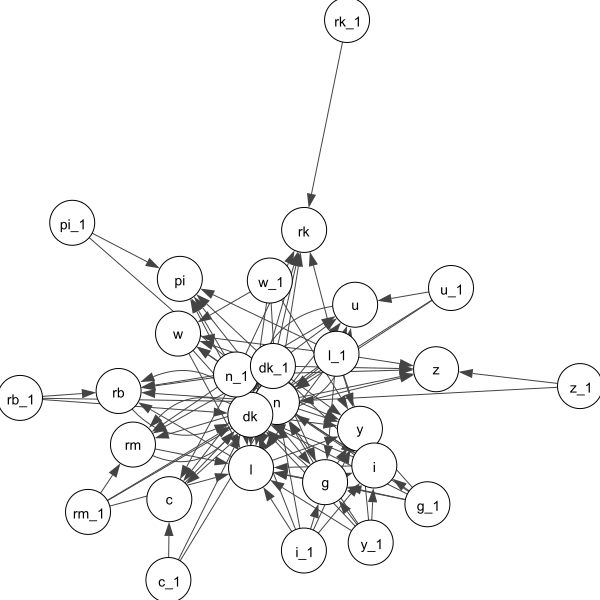

In [27]:
g = dg.plot_structure()
igraph.plot(g)

In [65]:
x_0 = pd.Series(np.full(len(dg.nodes), np.nan), index=dg.nodes)
shock_var = 'z'
shock_amt = statistics.stdev(data[shock_var])
x_0[np.where(data.columns == shock_var)[0]] = shock_amt
x_0[14:] = 0

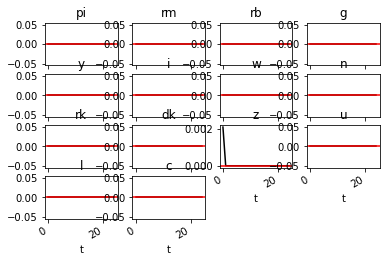

In [66]:
irf = dg.calculate_irf(x_0, T=25)
plt = dg.plot_irf(irf)
plt.show()

In [2]:
data = pd.read_csv('../data/real_data.csv')

In [4]:
data.set_index('DATE', inplace=True)

In [8]:
data.describe()

,pi,rm,rb,g,y,i,w,n,rk,dk,z,u,l,c
count,1.010000e+02,1.010000e+02,1.010000e+02,1.010000e+02,1.010000e+02,1.010000e+02,1.010000e+02,1.010000e+02,1.010000e+02,1.010000e+02,1.010000e+02,1.010000e+02,1.010000e+02,1.010000e+02
mean,-3.993299e-19,1.209154e-17,3.435096e-18,-1.011292e-16,7.035077e-16,-6.050166e-15,7.914461e-17,-1.276246e-08,3.639055e-19,3.331812e-13,-1.272059e-19,5.530505e-17,-5.051185e-14,-4.039673e-17
std,1.385107e-03,1.065727e+00,6.234008e-01,1.915015e+01,6.857580e+01,4.752036e+01,2.751483e+00,5.980878e+05,6.254946e-04,7.120347e+03,2.110827e-03,2.926145e-01,3.234700e+02,2.295398e-01
min,-3.731837e-03,-3.805439e+00,-2.356388e+00,-4.281505e+01,-2.204967e+02,-1.273590e+02,-6.107308e+00,-1.081917e+06,-3.056724e-03,-1.808537e+04,-7.083657e-03,-8.690079e-01,-7.108293e+02,-5.276057e-01
25%,-7.892925e-04,-3.031020e-01,-3.290625e-01,-1.254288e+01,-3.405241e+01,-2.637913e+01,-1.100505e+00,-3.161943e+05,-1.557150e-04,-3.266430e+03,-1.030250e-03,-1.562225e-01,-2.092811e+02,-1.192019e-01
50%,3.617103e-05,7.390034e-02,-3.568811e-02,1.346550e+00,1.658007e+00,-9.477259e-01,-9.914461e-02,-1.245721e+05,-6.669547e-07,7.239219e+02,2.638079e-05,-5.902453e-02,5.811071e+00,-3.237857e-02
75%,9.038523e-04,3.470842e-01,3.003303e-01,1.017348e+01,3.986396e+01,3.595927e+01,1.903577e+00,2.187258e+05,2.356912e-04,5.044540e+03,1.061278e-03,1.029721e-01,1.918908e+02,1.342555e-01
max,3.633154e-03,6.038126e+00,1.533827e+00,3.570167e+01,1.585022e+02,1.170423e+02,8.913101e+00,2.995193e+06,2.348672e-03,1.622589e+04,4.796986e-03,1.107352e+00,1.302367e+03,7.340046e-01
